In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Data

In [2]:
df = pd.read_csv(r"D:\Study\BA\train.csv")

### Checking the Data

In [3]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,7981,CA-2015-103800,03-01-2015,07-01-2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095.0,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
1,740,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
2,741,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
3,742,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
4,1760,CA-2015-141817,05-01-2015,12-01-2015,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143.0,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


In [6]:
df.shape

(9800, 18)

### Setting up the Time Data with Date as an index and summing up in montly format

In [22]:
df["Date"] = pd.to_datetime(df["Order Date"])

In [23]:
df = df.set_index("Date")

In [24]:
ts = pd.DataFrame(df.Sales.resample("W").sum())

In [25]:
ts.tail()

,Sales
Date,
2018-12-02,21565.0600
2018-12-09,7261.7420
2018-12-16,14181.0200
2018-12-23,19457.0680
2018-12-30,15210.8858


In [26]:
ts.shape

(209, 1)

In [27]:
ts = ts.tail(106)

In [169]:
ts.shape

(106, 1)

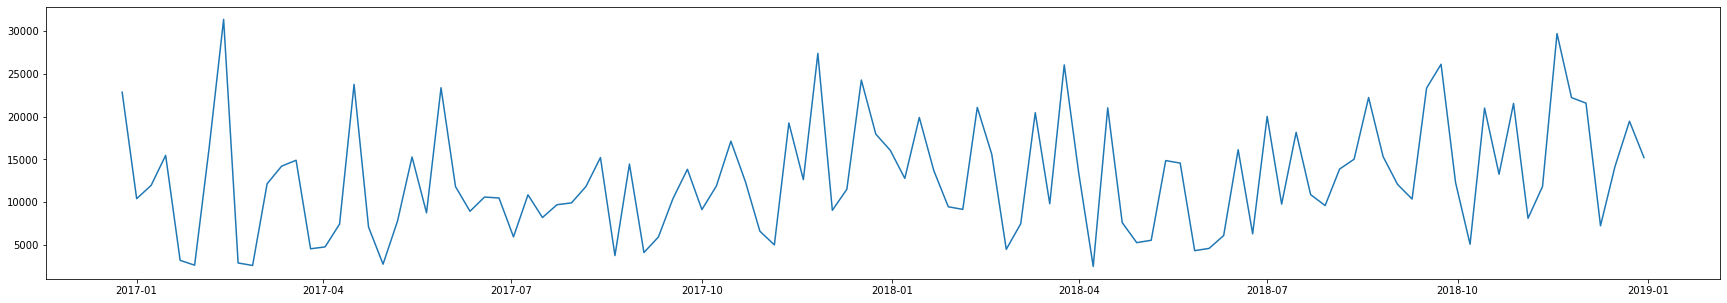

In [28]:
plt.figure(figsize=(30,5))
plt.plot(ts)

### Checking the stationarity with Dicky Fuller Test

In [29]:
from statsmodels.tsa.stattools import adfuller
dtest = adfuller(ts)
print('P-Value: %f' % dtest[1])

P-Value: 0.048007


### P value is more than 0.05 hence Conversion require, Log Transformation and Diffrancing needed

In [30]:
ts_log = np.log(ts)

In [31]:
ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff = ts_log_diff.dropna(axis=0)

In [32]:
dtest = adfuller(ts_log_diff)
print('P-Value: %f' % dtest[1])

P-Value: 0.000000


### Checking Decompose

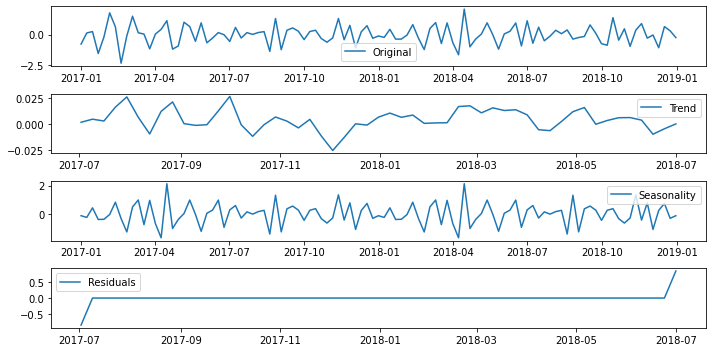

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(ts_log_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Trend seems to be more stable but increasing in long term, Seasonality seems to touch the peak during the december times

### Checking ACF and PACF 

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

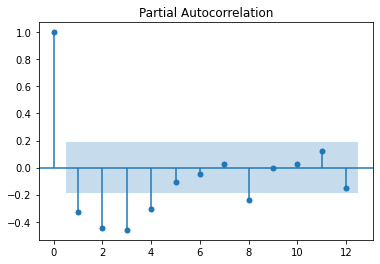

In [224]:
PACF = plot_pacf(ts_log_diff,lags=12)

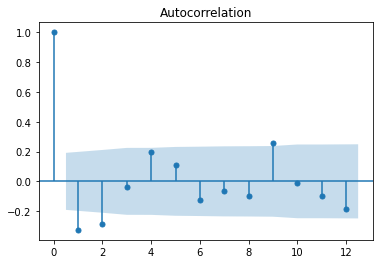

In [225]:
ACF = plot_acf(ts_log_diff,lags=12)

### Both ACF And PACF seems to have good correlation at 7th lag

### calling Library

In [226]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Spliting the data from 106 Weeks to 84:22  (Train:Test) to check the accuracy of the model

In [227]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ts,test_size=0.20,shuffle=False)

In [228]:
train.shape,test.shape

((84, 1), (22, 1))

In [229]:
from statsmodels.tsa.arima_model import ARIMA

### 24 represent 2 Qtrs

In [273]:
model=sm.tsa.statespace.SARIMAX(train,order=(3, 1, 1),seasonal_order=(3 ,1 ,1 ,24),enforce_stationarity=True,enforce_invertibility=True,trend="n",simple_differencing=False,n_jobs=-1)
results=model.fit()

In [274]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   84
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 24)   Log Likelihood                -607.519
Date:                            Sun, 01 May 2022   AIC                           1233.037
Time:                                    16:21:31   BIC                           1251.735
Sample:                                12-25-2016   HQIC                          1240.336
                                     - 07-29-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1603      0.638     -0.251      0.802      -1.411       1.090
ar.L2         -0.2412      0.475     -0.508      0.612      -1.172       0.690
ar.L3          0.0115      0.458      0.025      0.980      -0.885       0.908
ma.L1         -0.7006      0.569     -1.232      0.218      -1.816       0.414
ar.S.L24      -0.3622   1598.484     -0.000      1.000   -3133.333    3132.608
ar.S.L48       0.1412   1292.984      0.000      1.000   -2534.061    2534.344
ar.S.L72       0.0823    338.583      0.000      1.000    -663.528     663.693
ma.S.L24      -0.4494   1598.944     -0.000      1.000   -3134.322    3133.423
sigma2       8.25e+07      0.223    3.7e+08      0.000    8.25e+07    8.25e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.59   Prob(JB):                         0.73
Heteroskedasticity (H):               2.07   Skew:                             0.20
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+24. Standard errors may be unstable.
"""

In [275]:
prediction = results.forecast(steps=22)

### Checking MAPE Score
##### <0.10 Highly Accurate
##### 0.10 - 0.20 Good
##### 0.20 - 0.50 Reasonable Forecasting
##### >0.50 Inaccurate

In [276]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [277]:
print(MAPE(test,prediction))

0.298358957949591


### Comparing the results from our prediction and the test data that was split

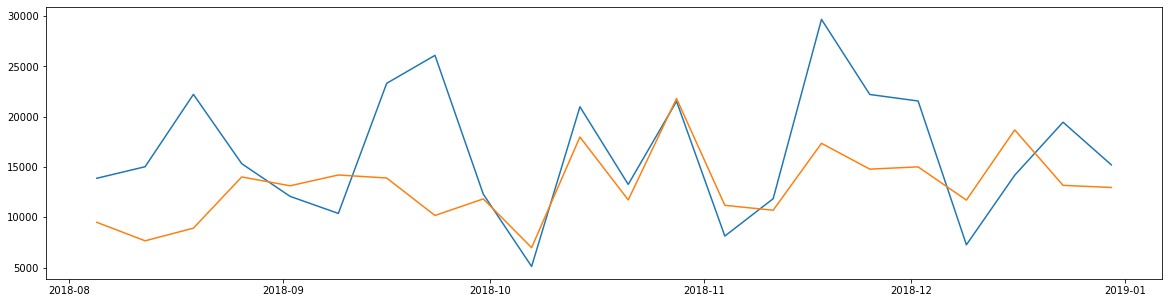

In [278]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(pd.DataFrame(prediction))

In [279]:
concat = [prediction,test]

In [280]:
pd.concat(concat,axis=1)

,predicted_mean,Sales
2018-08-05,9495.929432,13877.9680
2018-08-12,7659.170245,15027.1260
2018-08-19,8917.669597,22222.5540
2018-08-26,14010.561768,15330.0720
2018-09-02,13130.704258,12080.7230
2018-09-09,14205.808249,10382.1440
2018-09-16,13905.218942,23322.4700
2018-09-23,10177.123662,26104.4330
2018-09-30,11826.735232,12296.0620
2018-10-07,6979.527229,5108.1410


### Checking Residual

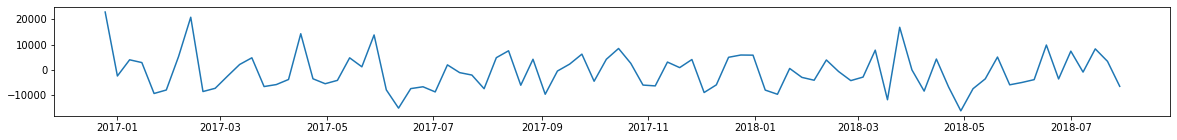

In [281]:
residuals = pd.DataFrame(results.resid)
plt.figure(figsize=(20,2))
plt.plot(residuals)

                  0
count     84.000000
mean    -603.768474
std     7469.092524
min   -16139.709673
25%    -6337.565978
50%    -2200.679370
75%     4230.951054
max    22843.047000


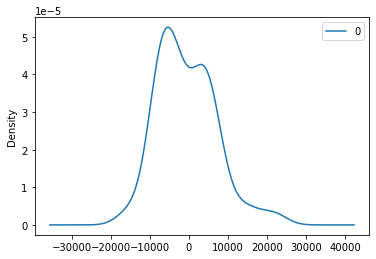

In [282]:
residuals.plot(kind='kde')
print(residuals.describe())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

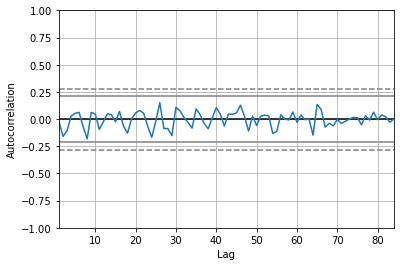

In [283]:
from pandas.plotting import autocorrelation_plot
#Residual autocorrelation plot
autocorrelation_plot(residuals)

### Creating the Data Frame to predict for the future

In [284]:
from pandas.tseries.offsets import DateOffset
pred_dates=pd.Series(pd.date_range("1/1/2019", freq="W", periods=4))
pred_dates_ts=pd.DataFrame(index=pred_dates[1:],columns=ts.columns)

In [285]:
pred = pd.concat([ts,pred_dates_ts])
pred['forecast'] = results.forecast(steps=48)

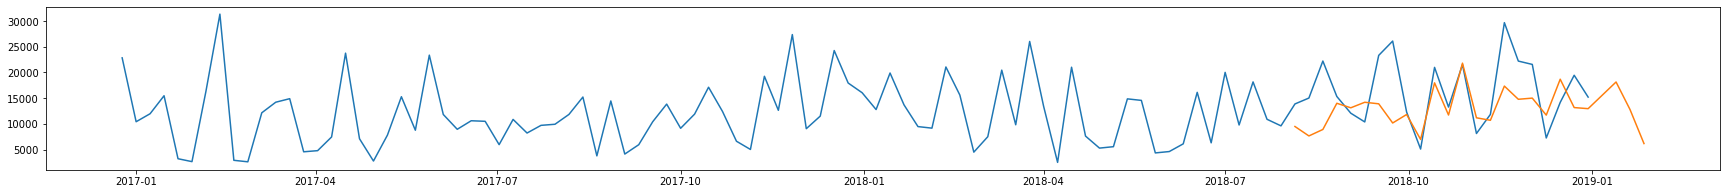

In [286]:
plt.figure(figsize=(30,3))
plt.plot(pred)

In [287]:
pred.tail(12)

,Sales,forecast
2018-11-04,8131.6480,11186.335446
2018-11-11,11847.2050,10698.988867
2018-11-18,29686.0960,17353.272999
2018-11-25,22212.7690,14787.254888
2018-12-02,21565.0600,15011.604715
2018-12-09,7261.7420,11707.216139
2018-12-16,14181.0200,18688.311663
2018-12-23,19457.0680,13174.492073
2018-12-30,15210.8858,12961.748200
2019-01-13,NaN,18149.070149


In [253]:
pred.to_excel("Week Results_Superstore_Sales.xlsx")